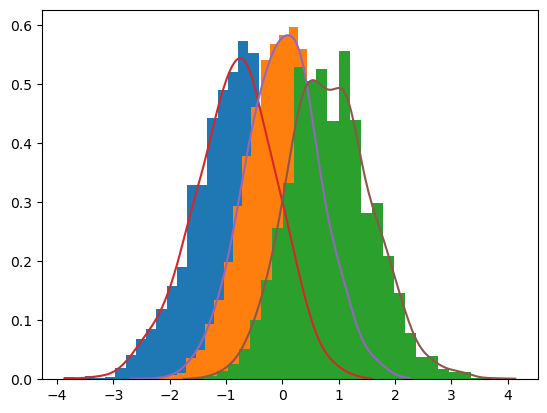

In [83]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns


def get_gaussian_density(dataset):
    ''' Гауссово распределение, полученное на основе выборки

        :param dataset: массив значений
    '''

    density = ss.gaussian_kde(dataset)
    density.covariance_factor = lambda : 0.25
    density._compute_covariance()

    min_x, max_x = np.percentile(dataset, [0, 100])

    return np.linspace(min_x, max_x, 200), density




mu, sigma = 0, 1 # Среднее и стандартное отклонение
rnd = np.random.normal(mu, sigma, 10000)  # Выборка случайно распределенной величины


# Случайно выбираем по 3 пробы, сортируем их
random_samples = (
  sorted(np.random.choice(rnd, 3))
  for i in range(10000)
)

# Zip функция - без комментариев (функциональное программирование, есть на Вики)
# на выходе получаем массивы минимальных, средних и максимальных значений
rnd1, rnd2, rnd3 = zip(*random_samples)


# Гистограмма частот распределения случайной величины (опционально)
counts_1, x_range_1, ignored = plt.hist(rnd1, 30, density=True, histtype='barstacked')
counts_2, x_range_2, ignored = plt.hist(rnd2, 30, density=True, histtype='barstacked')
counts_3, x_range_3, ignored = plt.hist(rnd3, 30, density=True, histtype='barstacked')


# Гауссова оценка плотности ядра (приближение к гладкой функции)
x1, linear_1 = get_gaussian_density(rnd1)
x2, linear_2 = get_gaussian_density(rnd2)
x3, linear_3 = get_gaussian_density(rnd3)


plt.plot(x1, linear_1(x1))
plt.plot(x2, linear_2(x2))
plt.plot(x3, linear_3(x3))


plt.show()


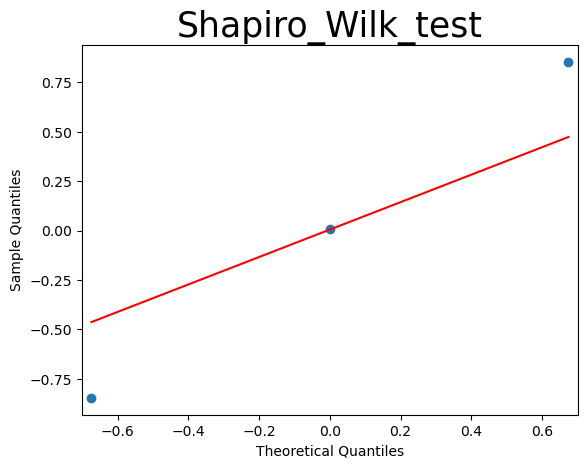

0.0073871041362326695

In [84]:
# создаем QQ-plot с помощью statsmodels, в качестве аргумента 'expr' из отсортированного датасета

res = pd.DataFrame({"rnd1": rnd1, 
              'rnd2': rnd2, 
              "rnd3": rnd3}).mean()

sm.qqplot(res, line='s')

# добавляем название графика

plt.title('Shapiro_Wilk_test', fontsize=25)

# выводим на экран 

plt.show()

l = res['rnd1'] + res['rnd3']

l

C:\Users\Валерий\AppData\Local\Temp\ipykernel_8036\1917215855.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range("2024-01-01", periods=n_samples, freq="1H")


Month 2 means are not normally distributed. Can't use t-test


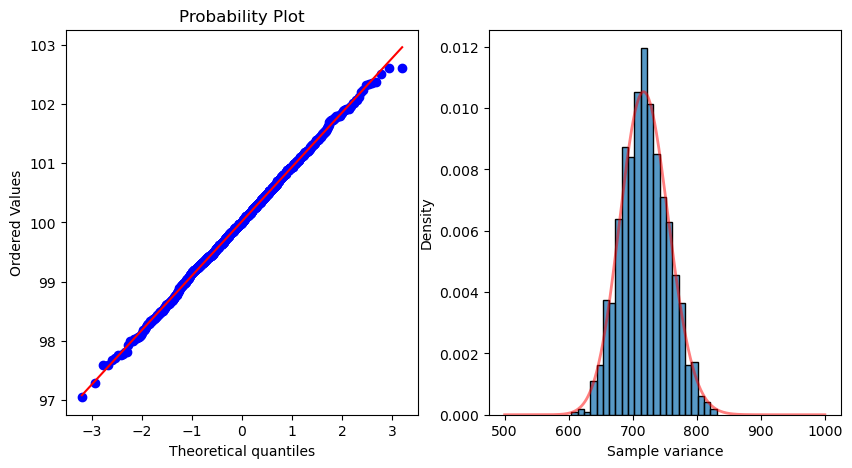

p-value: 0.000


In [85]:

# Функция генерации данных
def generate_data(
    n_samples: int, loc1: int = 100, scale1: int = 10, loc2: int = 99, scale2: int = 10
) -> pd.DataFrame:
    time = pd.date_range("2024-01-01", periods=n_samples, freq="1H")
    data = np.concatenate(
        (
            np.random.normal(loc=loc1, scale=scale1, size=n_samples // 2),
            np.random.normal(loc=loc2, scale=scale2, size=n_samples - n_samples // 2),
        )
    )
    return pd.DataFrame({"time": time, "metric": data})


ONE_MONTH = 24 * 30
test_data = generate_data(ONE_MONTH * 2)

data_month1 = test_data.iloc[:ONE_MONTH].metric
data_month2 = test_data.iloc[ONE_MONTH:].metric


# Проведем тест на нормальность распределения средних для первого и второго месяца
# Функция получения средних для сэмплированных подвыборок
def sample_means(data, n_samples=100, n_iterations=1000):
    means = np.zeros(n_iterations)
    for i in range(n_iterations):
        sample = np.random.choice(data, size=n_samples, replace=True)
        means[i] = sample.mean()
    return means


month_1_means = sample_means(data_month1)
month_2_means = sample_means(data_month2)

if ss.shapiro(month_1_means).pvalue < 0.05:
    print("Month 1 means are not normally distributed. Can't use t-test")
if ss.shapiro(month_2_means).pvalue < 0.05:
    print("Month 2 means are not normally distributed. Can't use t-test")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# QQ-график для средних в первом месяце
ss.probplot(month_1_means, dist="norm", plot=ax1)


# тест на распределение chi2 средних значений за 1-й и 2-й месяцы
def sample_variances(data, n_iterations=1000):
    variances = np.zeros(n_iterations)
    for i in range(n_iterations):
        sample = np.random.choice(data, size=len(data), replace=True)
        variances[i] = sample.var()
    return variances


# график распределения выборочной диспресии за месяц 1 по оси ax2
month1_variances = sample_variances(data_month1)
n1 = len(data_month1)
sns.histplot(
    month1_variances * (n1 - 1) / data_month1.var(),
    stat="density",
    label="sample variance",
    ax=ax2,
)

# построить график плотности распределения chi2 с n1-1 степенями свободы на ax2
x = np.linspace(500, 1000, 1000)
ax2.plot(x, ss.chi2.pdf(x, n1 - 1), color="red", linewidth=2, alpha=0.5)
ax2.set_xlabel("Sample variance")
ax2.set_ylabel("Density")
plt.show()

print(f"p-value: {ss.ttest_ind(month_1_means, month_2_means).pvalue:.3f}")
